In [1]:
import datetime
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

print(os.getpid())

def init_spark(app_name, master):
    """
    :params app_name: Name of the app
    :params master_config: eg. local[4]
    :returns SparkContext
    """
    spark = SparkSession.builder.appName(app_name)\
                        .master(master)\
                        .getOrCreate() # Avoid duplicately create SparkSession
    
    return spark

spark = init_spark("Term Project", "local")

# Adjust the date below, and you can get the date format from start to end
date_start = datetime.datetime(2020, 11, 1,hour=0)
date_end = datetime.datetime(2020, 11, 13,hour=0)
date_delta = datetime.timedelta(hours=1)
date = date_start

df = []
init = 0
head = StructType([\
    StructField("VehicleType", IntegerType(), True),\
    StructField("DetectionTime_O", StringType(), True),\
    StructField("GantryID_O", StringType(), True),\
    StructField("DetectionTime_D", StringType(), True),\
    StructField("GantryID_D", StringType(), True),\
    StructField("TripLength", DoubleType(), True),\
    StructField("TripEnd", StringType(), True),\
    StructField("TripInformation", StringType(), True)])

## Load data to df
while date_start < date_end:
    
    # convert date to string by a assigned format
    dir_path = date.strftime("M06A/%Y%m%d/%H/") 
    filename = date.strftime("TDCS_M06A_%Y%m%d_%H0000.csv")
    path = dir_path + filename
#     print(path)
    
    # read csv by panda
#     temp = pd.read_csv(path, low_memory=False, header=None, names=["VehicleType", "DetectionTime_O", "GantryID_O", "DetectionTime_D", "GantryID_D", "TripLength", "TripEnd","TripInformation"])
#     df.append(temp)
    # read csv by spark
    print('load file:',path)
    if init == 0:
        df = spark.read.csv(path,header=False,schema=head)
        init = 1
    else:
        tmp = spark.read.csv(path,header=False,schema=head)
        df = df.union(tmp)
    # increment the date iterator
    date = date_start + date_delta
    date_start = date
print("done")

1610
load file: M06A/20201101/00/TDCS_M06A_20201101_000000.csv
load file: M06A/20201101/01/TDCS_M06A_20201101_010000.csv
load file: M06A/20201101/02/TDCS_M06A_20201101_020000.csv
load file: M06A/20201101/03/TDCS_M06A_20201101_030000.csv
load file: M06A/20201101/04/TDCS_M06A_20201101_040000.csv
load file: M06A/20201101/05/TDCS_M06A_20201101_050000.csv
load file: M06A/20201101/06/TDCS_M06A_20201101_060000.csv
load file: M06A/20201101/07/TDCS_M06A_20201101_070000.csv
load file: M06A/20201101/08/TDCS_M06A_20201101_080000.csv
load file: M06A/20201101/09/TDCS_M06A_20201101_090000.csv
load file: M06A/20201101/10/TDCS_M06A_20201101_100000.csv
load file: M06A/20201101/11/TDCS_M06A_20201101_110000.csv
load file: M06A/20201101/12/TDCS_M06A_20201101_120000.csv
load file: M06A/20201101/13/TDCS_M06A_20201101_130000.csv
load file: M06A/20201101/14/TDCS_M06A_20201101_140000.csv
load file: M06A/20201101/15/TDCS_M06A_20201101_150000.csv
load file: M06A/20201101/16/TDCS_M06A_20201101_160000.csv
load file

load file: M06A/20201107/06/TDCS_M06A_20201107_060000.csv
load file: M06A/20201107/07/TDCS_M06A_20201107_070000.csv
load file: M06A/20201107/08/TDCS_M06A_20201107_080000.csv
load file: M06A/20201107/09/TDCS_M06A_20201107_090000.csv
load file: M06A/20201107/10/TDCS_M06A_20201107_100000.csv
load file: M06A/20201107/11/TDCS_M06A_20201107_110000.csv
load file: M06A/20201107/12/TDCS_M06A_20201107_120000.csv
load file: M06A/20201107/13/TDCS_M06A_20201107_130000.csv
load file: M06A/20201107/14/TDCS_M06A_20201107_140000.csv
load file: M06A/20201107/15/TDCS_M06A_20201107_150000.csv
load file: M06A/20201107/16/TDCS_M06A_20201107_160000.csv
load file: M06A/20201107/17/TDCS_M06A_20201107_170000.csv
load file: M06A/20201107/18/TDCS_M06A_20201107_180000.csv
load file: M06A/20201107/19/TDCS_M06A_20201107_190000.csv
load file: M06A/20201107/20/TDCS_M06A_20201107_200000.csv
load file: M06A/20201107/21/TDCS_M06A_20201107_210000.csv
load file: M06A/20201107/22/TDCS_M06A_20201107_220000.csv
load file: M06

In [2]:
df.printSchema()

root
 |-- VehicleType: integer (nullable = true)
 |-- DetectionTime_O: string (nullable = true)
 |-- GantryID_O: string (nullable = true)
 |-- DetectionTime_D: string (nullable = true)
 |-- GantryID_D: string (nullable = true)
 |-- TripLength: double (nullable = true)
 |-- TripEnd: string (nullable = true)
 |-- TripInformation: string (nullable = true)



In [3]:
sta_1 = '05F0287' # 南端
sta_2 = '05F0055' # 北端
dist = 28.7-5.5 # 
# select the data which goes through sta_1 and sta_2
df = df.filter((df.DetectionTime_O != df.DetectionTime_D) & df.TripInformation.contains(sta_1) & df.TripInformation.contains(sta_2))
# dropout the data which DetectionTime_O == DetectionTime_D
# df = df.drop((df.DetectionTime_O == df.DetectionTime_D))

df.show()

+-----------+-------------------+----------+-------------------+----------+----------+-------+--------------------+
|VehicleType|    DetectionTime_O|GantryID_O|    DetectionTime_D|GantryID_D|TripLength|TripEnd|     TripInformation|
+-----------+-------------------+----------+-------------------+----------+----------+-------+--------------------+
|         31|2020-11-01 00:41:06|  05F0438N|2020-11-01 01:21:40|  03F0337S|      66.3|      Y|2020-11-01 00:41:...|
|         32|2020-11-01 00:04:48|  03A0041S|2020-11-01 00:36:41|  05F0439S|      52.7|      Y|2020-11-01 00:04:...|
|         31|2020-11-01 00:05:10|  05F0309N|2020-11-01 00:36:51|  03F0337S|      58.2|      Y|2020-11-01 00:05:...|
|         31|2020-11-01 00:44:12|  05F0528N|2020-11-01 01:18:53|  03A0015N|      63.9|      Y|2020-11-01 00:44:...|
|         32|2020-11-01 00:02:16|  05F0287N|2020-11-01 00:20:31|  05F0055N|      26.3|      Y|2020-11-01 00:02:...|
|         31|2020-11-01 00:06:32|  03F0158S|2020-11-01 00:29:53|  05F030

In [4]:
# for index, row in df.iterrows():
#     check_time = 0 # check_time = 2 if the trip passed two ETC sensor
#     for triptime in row['TripInformation'].split('; '):
#         if len(re.findall(sta_1, triptime)) > 0:
#             df.loc[index,'sta_1_time'] = pd.Timestamp(triptime[:19])
#             check_time += 1   
#         if len(re.findall(sta_2, triptime)) > 0:
#             df.loc[index,'sta_2_time'] = pd.Timestamp(triptime[:19])
#             check_time += 1
#         if check_time > 1:
#             if df.loc[index,'sta_1_time'] < df.loc[index, 'sta_2_time']:
#                 df.loc[index,'direction'] = 'S'
#                 df.loc[index,'start'] = df.loc[index,'sta_1_time']
#                 df.loc[index,'end'] = df.loc[index,'sta_2_time'] 
#             else:
#                 df.loc[index,'direction'] = 'N'
#                 df.loc[index,'start'] = df.loc[index,'sta_2_time'] 
#                 df.loc[index,'end'] = df.loc[index,'sta_1_time'] 
#             df.loc[index, 'diff'] = df.loc[index, 'end'] - df.loc[index, 'start']
#             df.loc[index, 'avg_speed'] = round(dist / df.loc[index, 'diff'].total_seconds() * 3600, 1)
#             break
# df.head()

In [22]:
df = df.withColumn('pos1',F.instr(df.TripInformation, sta_1))
df = df.withColumn('pos2',F.instr(df.TripInformation, sta_2))
df = df.withColumn('sta_1_time', F.to_timestamp(df.TripInformation.substr(df.pos1 - 20, F.lit(19))).cast(LongType()))
df = df.withColumn('sta_2_time', F.to_timestamp(df.TripInformation.substr(df.pos2 - 20, F.lit(19))).cast(LongType()))
df = df.withColumn('diff', F.abs(df.sta_1_time - df.sta_2_time))
df = df.withColumn('avg_speed', F.round(F.lit(28.7-5.5) / df.diff * F.lit(3600), 1))
# df.select(F.regexp_extract('TripInformation',r'.{19}[05F0287]'))
# df.withColumn('sta_1_time', F.regexp_extract(df.TripInformation,".{19}[05F0287]", 1))

In [23]:
# df.printSchema()
df.show()

root
 |-- VehicleType: integer (nullable = true)
 |-- DetectionTime_O: string (nullable = true)
 |-- GantryID_O: string (nullable = true)
 |-- DetectionTime_D: string (nullable = true)
 |-- GantryID_D: string (nullable = true)
 |-- TripLength: double (nullable = true)
 |-- TripEnd: string (nullable = true)
 |-- TripInformation: string (nullable = true)
 |-- pos1: integer (nullable = true)
 |-- pos2: integer (nullable = true)
 |-- sta_1_time: long (nullable = true)
 |-- sta_2_time: long (nullable = true)
 |-- diff: long (nullable = true)
 |-- avg_speed: double (nullable = true)

+-----------+-------------------+----------+-------------------+----------+----------+-------+--------------------+----+----+----------+----------+----+---------+
|VehicleType|    DetectionTime_O|GantryID_O|    DetectionTime_D|GantryID_D|TripLength|TripEnd|     TripInformation|pos1|pos2|sta_1_time|sta_2_time|diff|avg_speed|
+-----------+-------------------+----------+-------------------+----------+----------+---

In [50]:
# fig, ax = plt.subplots()
# distplot(ax, spark.createDataFrame(df.avg_speed, ['avg_speed']))
speed = [row.avg_speed for row in df.select('avg_speed').collect()] # convert column to list
pd_df = spark.createDataFrame(speed,schema=FloatType()).toPandas() # convert list to pandas dataframe

KeyError: 'avg_speed'

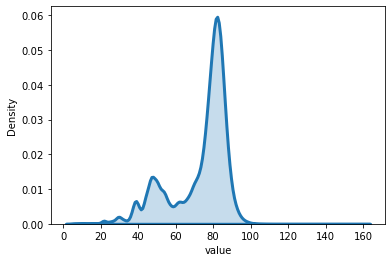

In [52]:
ax = sns.kdeplot(pd_df['value'],shade=True,linewidth=3) # pandas dataframe plot